# Nerf explanation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmosZhu/Shape_from_X/blob/main/Notebooks/Nerual_Scene/Nerf.ipynb)
[![Open In nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/AmosZhu/Shape_from_X/blob/main/Notebooks/Nerual_Scene/Nerf.ipynb?flush_cache=True)

This notebook will explain following ideas from NERF which include
- Raymarching equation in paper.
- Weigthed ray sampler.

What not cover:
- Positional encoding. (Which is crucial for quality of NERF, I explained in another notebook.)
- Rendering.

## 1. Raymarching equation
\begin{equation}
    C(r)=\int_{t_n}^{t_f} T(t) \sigma(r(t)) c(r(t),d) dt
\end{equation}
Where
- $r(t)=\mathbf{o}+t\mathbf{d}$ is a ray function.
- $c(r(t),d)$ is the color predict from Nerf. The color depends on 3d position and view(ray) direction.
- $\sigma(r(t))$ is the density predict from Nerf. It depends on 3d position of the space.


It tells the pixel color on the image is the integral of the color along the ray. Where $r(t)$ present a position on the ray, and $d$ is the ray direction.

In practical, we approximate the above equation in discrete form that:
\begin{equation}
    \hat{C}=\sum_{i=1}^{N} T_i \alpha_i c_i
\end{equation}
It tells the pixel color on the image is the integral of the color along the ray.
As in discrete world, we take $N$ sample along the ray, and in each ray sample position, it contains color and weight. The final color of this ray in image pixel is their weighted sum up.

### $\alpha$-The light contribution
**$\alpha_i$** define how much light contribute to the final output in this sample. And it is defined by
\begin{equation}
    \alpha_i=1-e^{-\sigma_i \delta_i}
\end{equation}
Where $\sigma$ is the surface density predict by Nerf, and $\delta_i$ is the distance between sample $i+1$ and $i$.

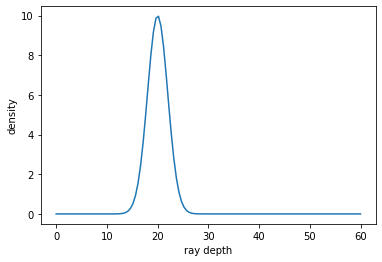

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


x_values = np.linspace(0, 60, 120)
density = gaussian(x_values, mu=20, sig=2) * 10

plt.plot(x_values, density)
plt.xlabel('ray depth')
plt.ylabel('density')
plt.show()

Where the density should be high nearby surface and 0 where there is no object. Intuitively, we should say that pixel color was most contribute by the surface. So let's plot what corresponding $\alpha$ should looks like.

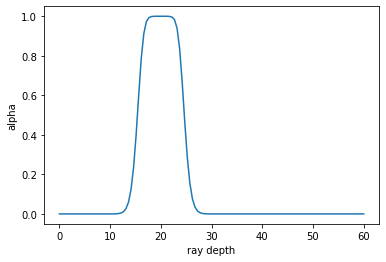

In [2]:
alpha_fun = lambda x: 1 - np.exp(-x)

alpha = alpha_fun(density)
plt.plot(x_values, alpha)
plt.xlabel('ray depth')
plt.ylabel('alpha')
plt.show()

You see the prediction density could be arbitrary value, but $\alpha$ make sure them normalise between $[0,1]$ and soft the density.

### $T$ - The surface opacity
While we see the $\alpha$ already played a role of weight that surface, then why we need $T$. Because a ray will penetrate multiple surfaces, the light energy will likely to decrease.

For example: a ray hit a solid surface then the objects behind the solid object should have very low(0) contribution to the final color. While the objects behind still has a high density though.

The definition of the light blockage is
\begin{equation}
    T_i=\prod_{k=1}^{k=i}(1-\alpha_k)
\end{equation}
Let's make up such a scenario.


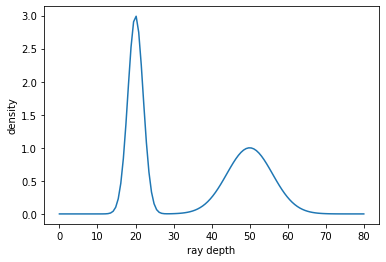

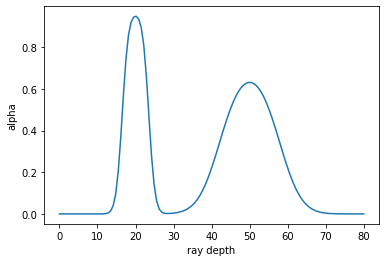

In [3]:
max_depth = 80
x_values = np.linspace(0, max_depth, 120)
y_values_1 = gaussian(x_values, mu=20, sig=2) * 3
# plt.plot(x_values, y_values)

y_values_2 = gaussian(x_values, mu=50, sig=6)

density = y_values_1 + y_values_2
plt.plot(x_values, density)
plt.xlabel('ray depth')
plt.ylabel('density')
plt.show()

alpha = alpha_fun(density)

plt.plot(x_values, alpha)
plt.xlabel('ray depth')
plt.ylabel('alpha')
plt.show()

Let's see what the T suppose like.

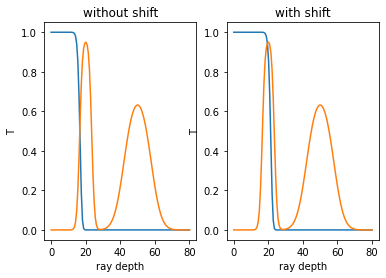

In [4]:
def _shifted_cumprod(x, shift: int = 1):
    x_cumprod = np.cumprod(x)
    x_cumprod_shift = np.concatenate(
        [np.ones_like(x_cumprod[..., :shift]), x_cumprod[..., :-shift]]
    )
    return x_cumprod_shift


T = _shifted_cumprod(1 - alpha)
plt.subplot(1, 2, 1)
plt.plot(x_values, T)
plt.plot(x_values, alpha)
plt.xlabel('ray depth')
plt.ylabel('T')
plt.title('without shift')

T = _shifted_cumprod(1 - alpha, shift=8)
plt.subplot(1, 2, 2)
plt.plot(x_values, T)
plt.plot(x_values, alpha)
plt.xlabel('ray depth')
plt.ylabel('T')
plt.title('with shift')

plt.show()

As you see, we also shift the function $T$ a little to make the light blockage after the highest density of the surface. You can see above figure when there is no shift, the $T_i=0$ when density is the highest, we might want to avoid it.


### The weight of color in each sample
So the weight of color in each sample is $w_i=\alpha_i \cdot T_i$. We use above example to see what it looks like.

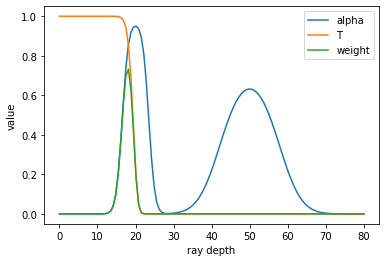

In [5]:
x_values = np.linspace(0, max_depth, 120)
y_values_1 = gaussian(x_values, mu=20, sig=2) * 3
y_values_2 = gaussian(x_values, mu=50, sig=6)

density = y_values_1 + y_values_2
alpha = alpha_fun(density)
T = _shifted_cumprod(1 - alpha, shift=5)
W = alpha * T

plt.plot(x_values, alpha)
plt.plot(x_values, T)
plt.plot(x_values, W)
plt.xlabel('ray depth')
plt.ylabel('value')
plt.legend(['alpha', 'T', 'weight'])
plt.show()

It's what we expected, the foremost surface dominant the weight of the color contribution.

## 2. Ray sampler by given PDF.
In the fine step of the NERF, the ray sample is following a probability density function(PDF). To achieve it we need use inverted CDF method. A review of the definition of the PDF and CDF.
\begin{equation}
    PDF(X)=P(a \leq X \leq b)=\int_{a}^{b} P(X) dX
\end{equation}
While $P$ denote the probability function, $X$ denotes the random variables.
\begin{equation}
    CDF(X)=P(X\leq a)=\int_{-\infty}^{a} P(X) dX
\end{equation}
You can see the CDF is the cumulative of the PDF.

Let's take the above weight as our PDF, and see what the CDF should be.

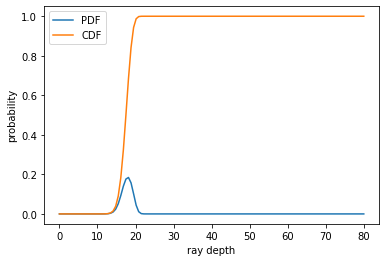

In [6]:
cdf_func = lambda x: np.cumsum(x)
w_pdf = W / np.sum(W) # normalise PDF
w_cdf = cdf_func(w_pdf)
plt.plot(x_values, w_pdf)
plt.plot(x_values, w_cdf)
plt.xlabel('ray depth')
plt.ylabel('probability')
plt.legend(['PDF', 'CDF'])
plt.show()

Let's define the CDF as $y=F(x)=CDF(x)$, and its inverted function is $x=F^{-1}(y)$. So to sample a PDF, we're following these steps:
- Compute the CDF from PDF.
- Compute the inverted CDF function.
- Uniform sample the inverted CDF, and the output will be following PDF distribution.

Basically the $x$ is the inverse of the CDF, so it has following the distribution of its PDF.

(100,)


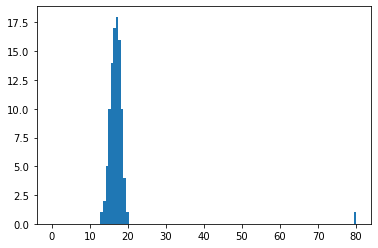

In [7]:
# inverted CDF
bin_width = max_depth / len(w_cdf)

Y = np.linspace(0, 1, 100)
index = np.searchsorted(w_cdf, Y, side='right') - 1

# map the index to real value of X
X = index * bin_width
print(X.shape)

plt.hist(X, bins=np.linspace(0, max_depth, 120))
plt.show()

You can see the sample distribution is similar with the PDF plot.
The inverted CDF works when:
- Normalise density.
- Low dimension variables.

Let's define the CDF as $y=F(x)=CDF(x)$, and its inverted function is $x=F^{-1}(y)$. So to sample a PDF, we're following these steps:
- Compute the CDF from PDF.
- Compute the inverted CDF function.
- Uniform sample the inverted CDF, and the output will be following PDF distribution.

Basically the $x$ is the inverse of the CDF, so it has following the distribution of its PDF.

(100,)


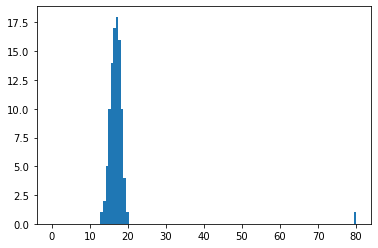

In [77]:
# inverted CDF
bin_width = max_depth / len(w_cdf)

Y = np.linspace(0, 1, 100)
index = np.searchsorted(w_cdf, Y, side='right') - 1

# map the index to real value of X
X = index * bin_width
print(X.shape)

plt.hist(X, bins=np.linspace(0, max_depth, 120))
plt.show()

You can see the sample distribution is similar with the PDF plot.
The inverted CDF works when:
- Normalise density.
- Low dimension variables.